##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 2,57
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.49;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]
filesInfected = [
    {"filename": "Netsim-Node-Metrics-IsInfected-{log_tag}", "title": "Доля инфицированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
summInfected = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatInfected():
    for file in filesInfected:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля инфицированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summInfected.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            dataI, line_lenI = load_csv_file(f"{log_dir_path}/{filesInfected[0]['filename'].format(log_tag = log_tag['tag'])}")
                                           
            aggregated, count = aggeregate_line_perc_node(data)
            aggregatedI, count = aggeregate_line_perc_node(dataI)
            aggregated = np.array(aggregated) - np.array(aggregatedI)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    showStatInfected();

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

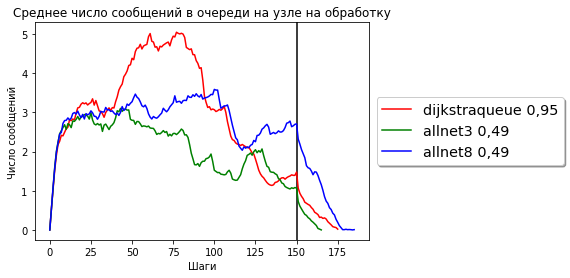

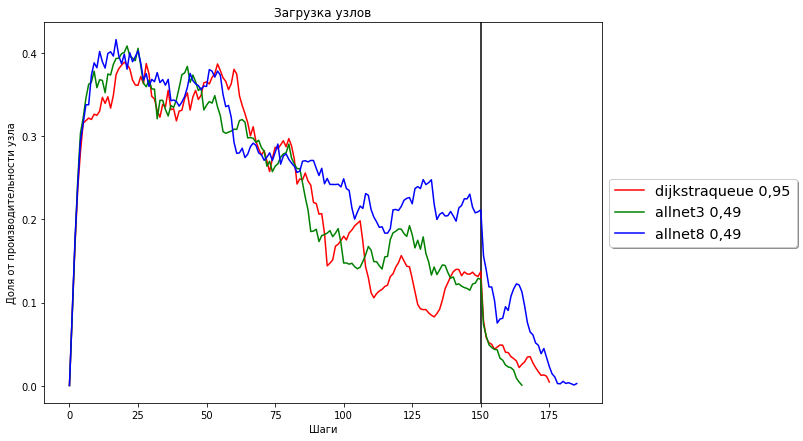

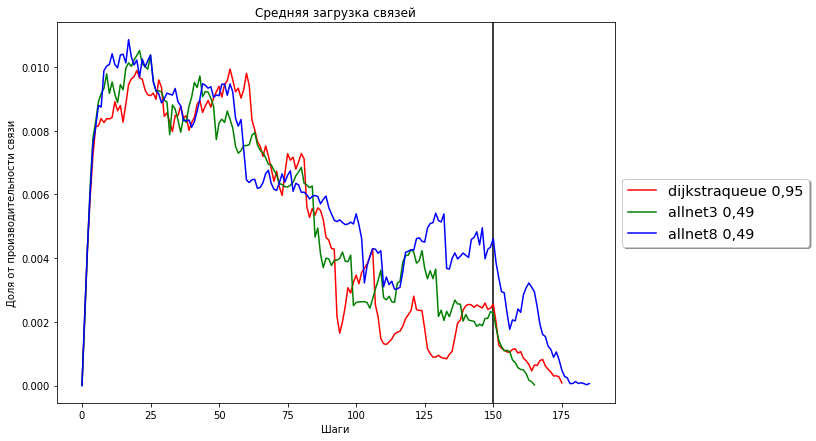

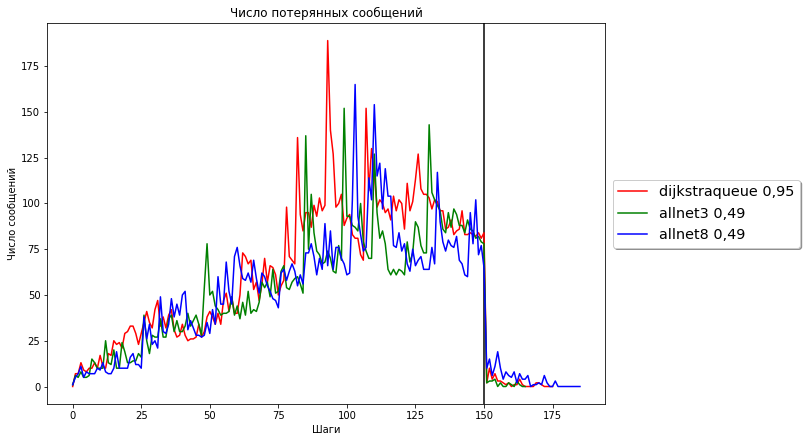

Доставлено 5098 Потеряно 66.0156% -dijkstraqueue 0,95
Доставлено 6564 Потеряно 56.2429% -allnet3 0,49
Доставлено 6435 Потеряно 57.1029% -allnet8 0,49


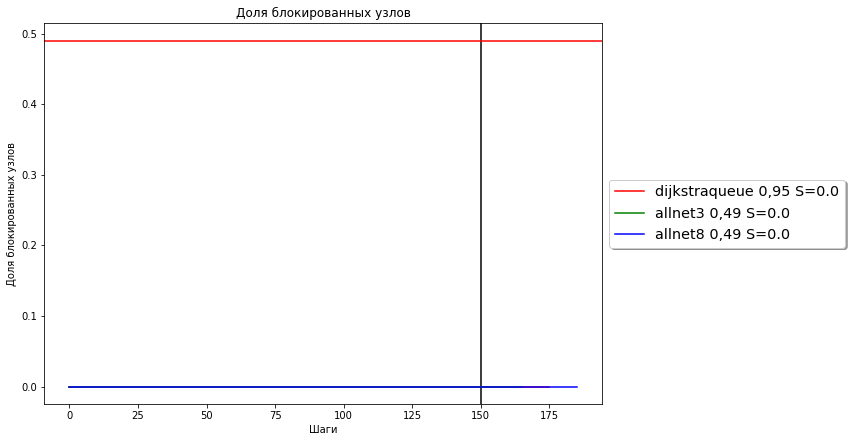

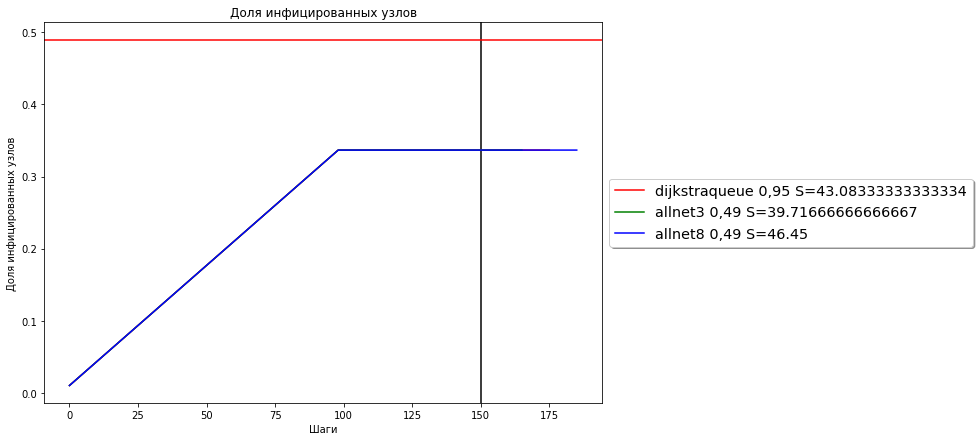

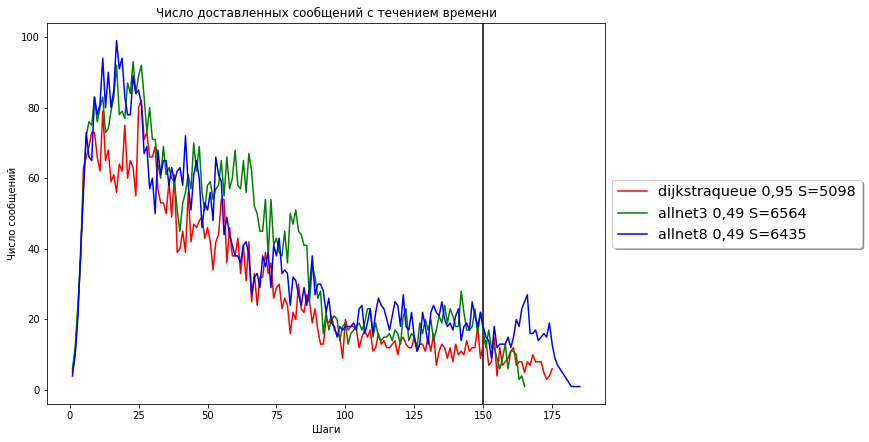

In [2]:
quantity = 100;
log_tags = [
{"tag":  "f6d0ad72-c585-474e-862b-fdcfabebddbd", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "466e5a8c-b31b-4dcd-8870-7f12fe5164fb", "label": "allnet3 0,49", "color": "green"},
{"tag":  "b81197af-5da4-4ec3-92cf-0b9c9047cd27", "label": "allnet8 0,49", "color": "blue"},
]                        
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

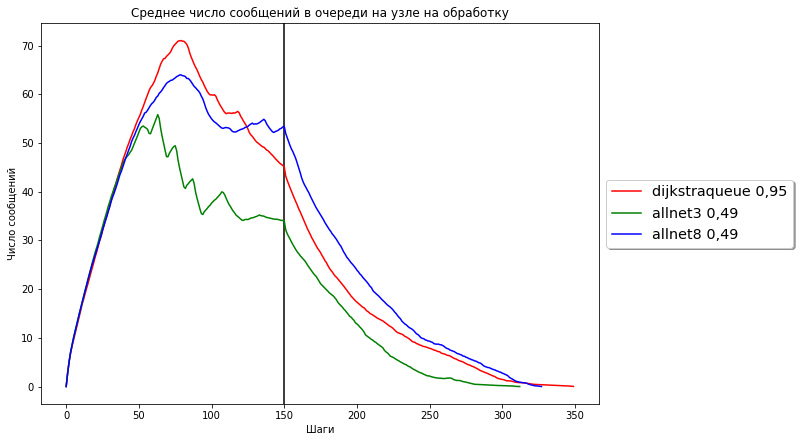

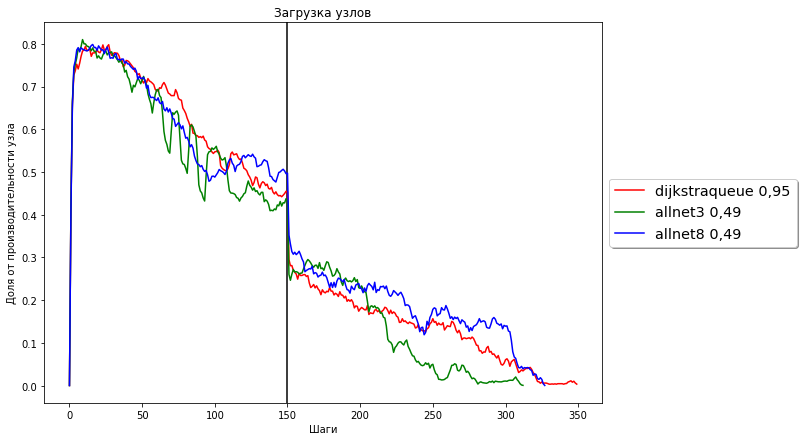

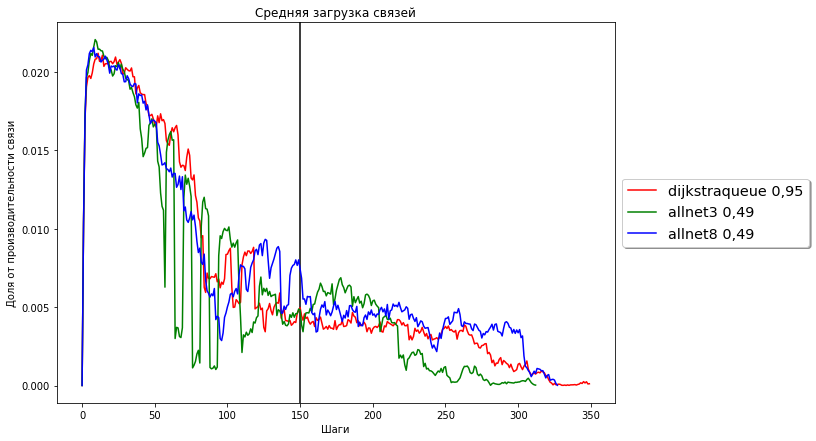

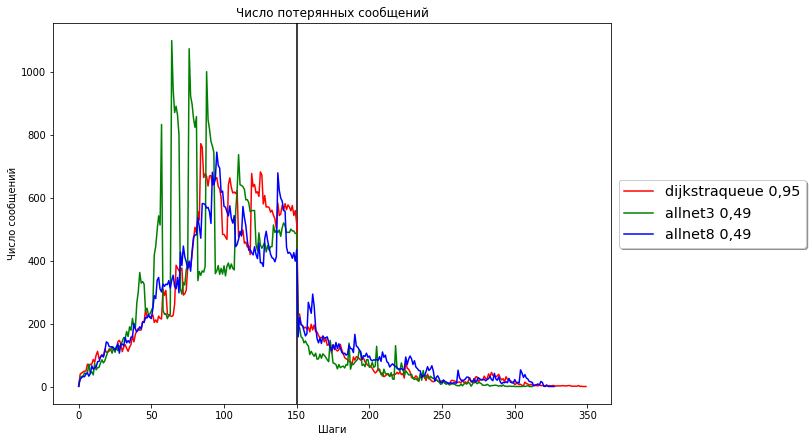

Доставлено 9281 Потеряно 87.6255% -dijkstraqueue 0,95
Доставлено 8242 Потеряно 89.0108% -allnet3 0,49
Доставлено 10539 Потеряно 85.9482% -allnet8 0,49


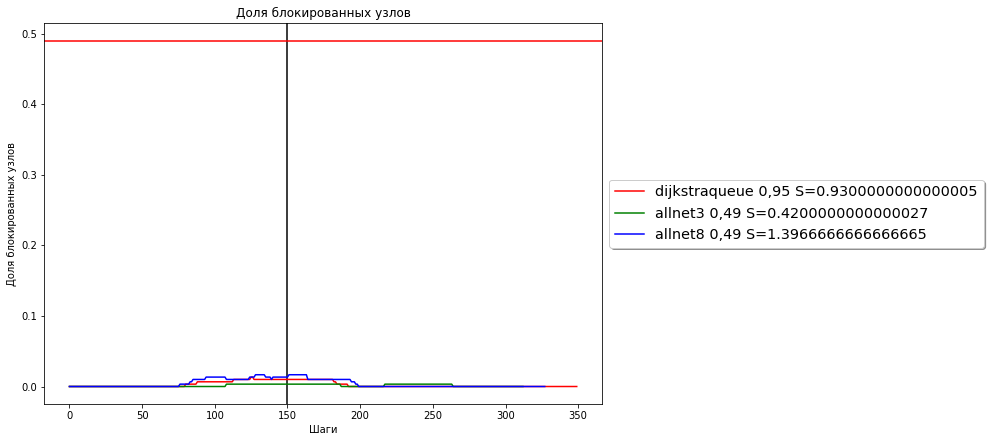

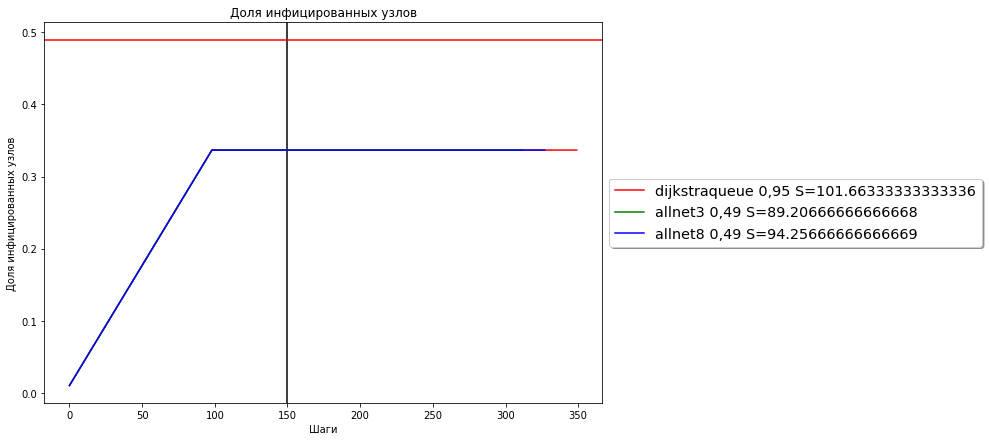

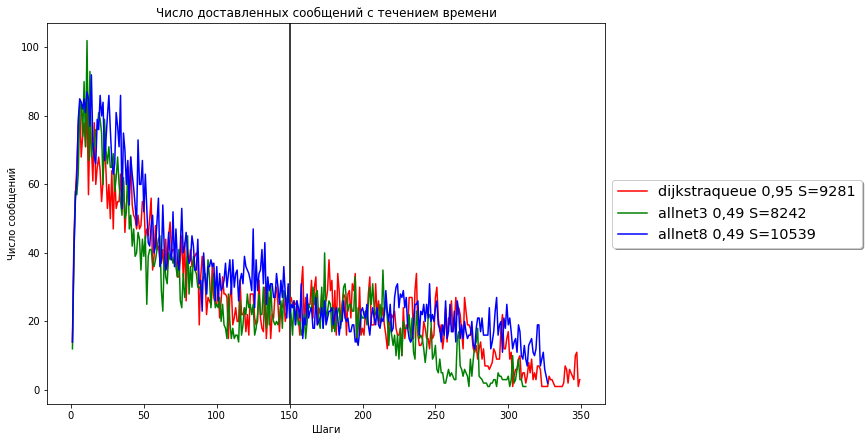

In [3]:
quantity = 500;
log_tags = [
{"tag":  "33e8015f-129b-4e47-ac4c-bfccc5a9a85a", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "387792c5-a4a9-4d7c-b356-347c71e8fece", "label": "allnet3 0,49", "color": "green"},
{"tag":  "908ce122-f38e-4b22-b830-70862c00e0e3", "label": "allnet8 0,49", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

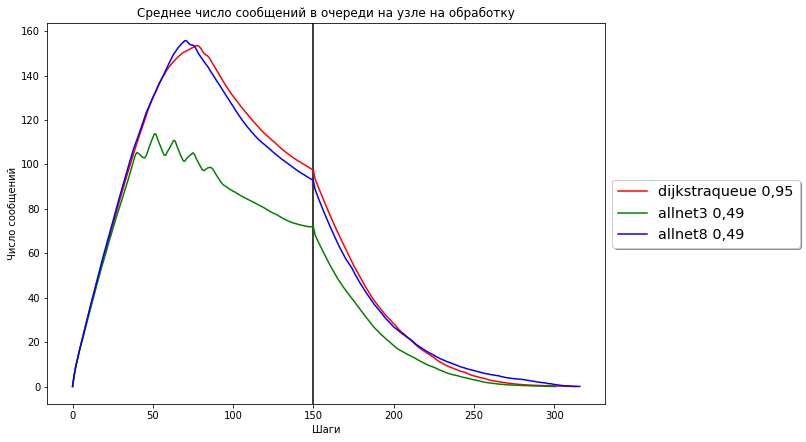

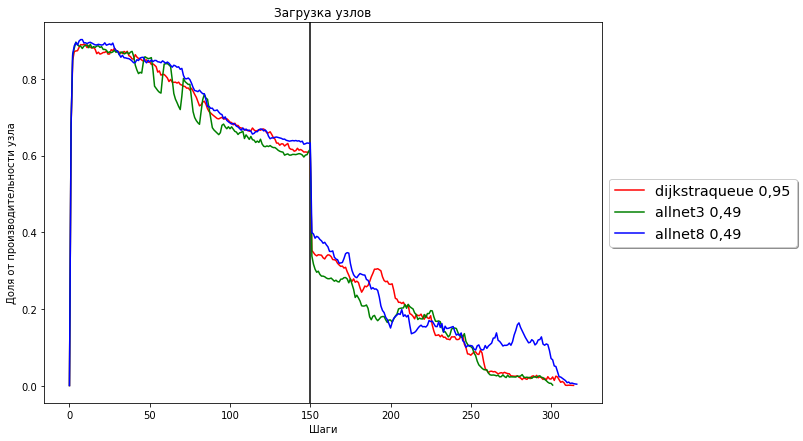

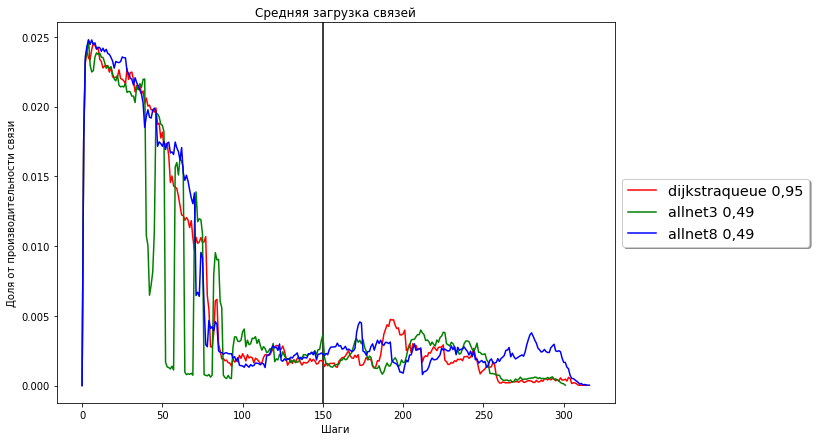

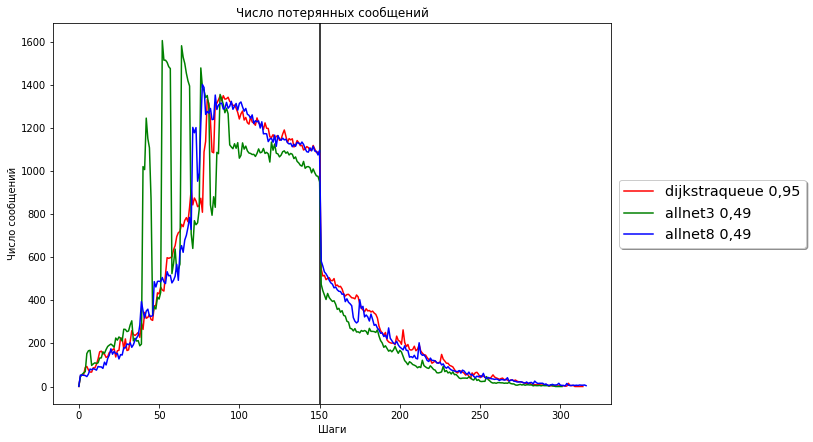

Доставлено 7775 Потеряно 94.8167% -dijkstraqueue 0,95
Доставлено 7751 Потеряно 94.8327% -allnet3 0,49
Доставлено 8449 Потеряно 94.3674% -allnet8 0,49


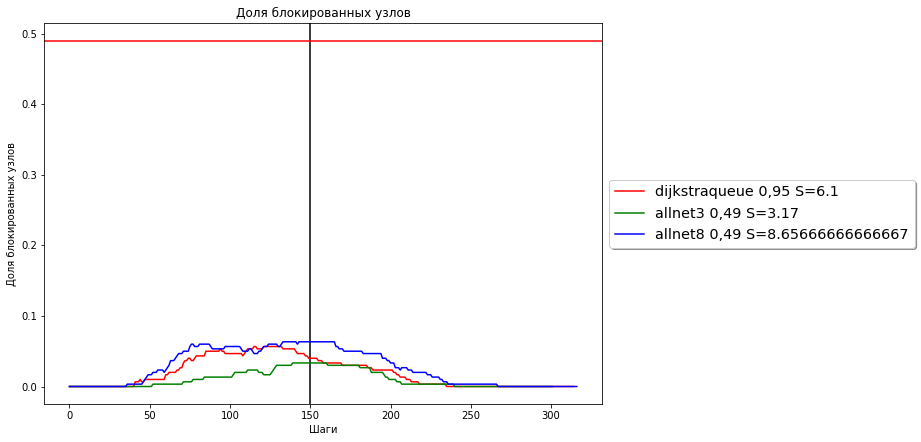

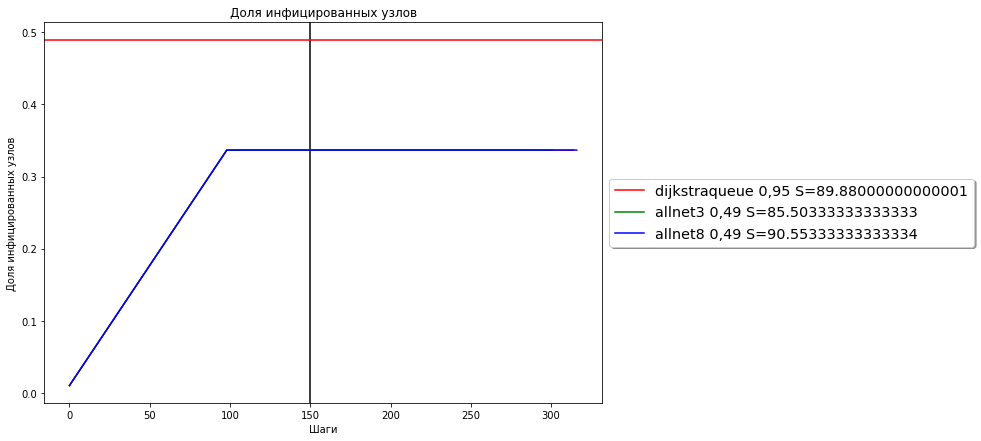

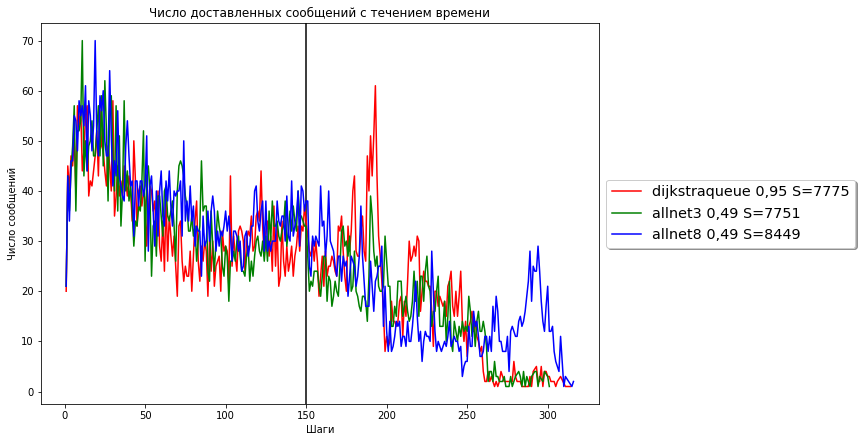

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "a021b3b4-3d2c-49d5-8dae-c2f8c8bf26f5", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "7be32118-85e6-4be1-bea1-15085d338289", "label": "allnet3 0,49", "color": "green"},
{"tag":  "30feb569-9023-4526-be7e-fb8dcfa21c69", "label": "allnet8 0,49", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

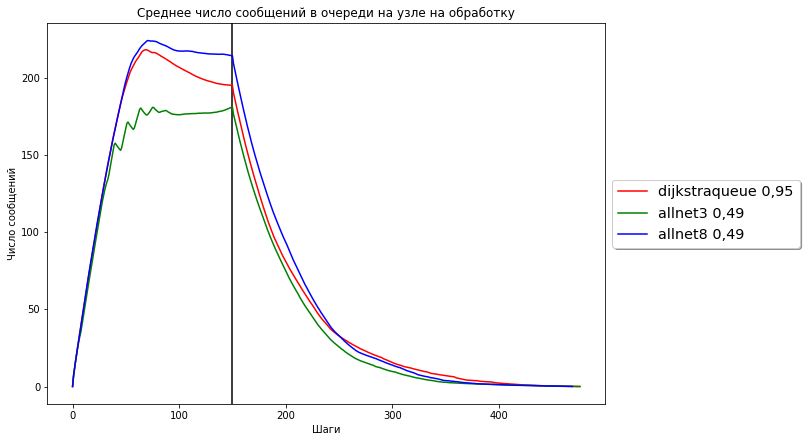

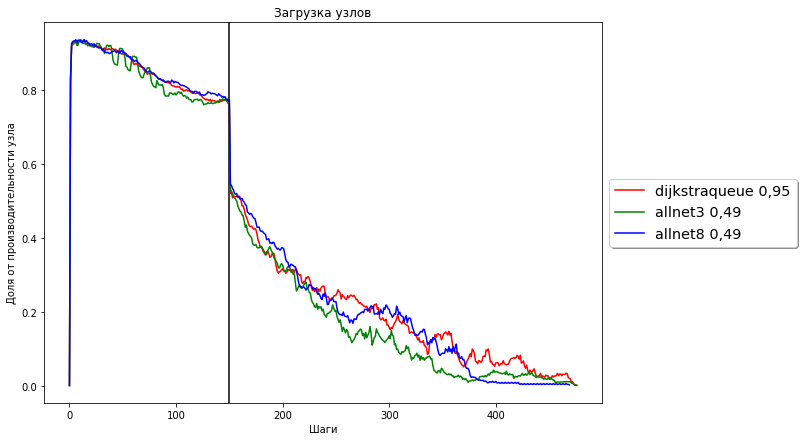

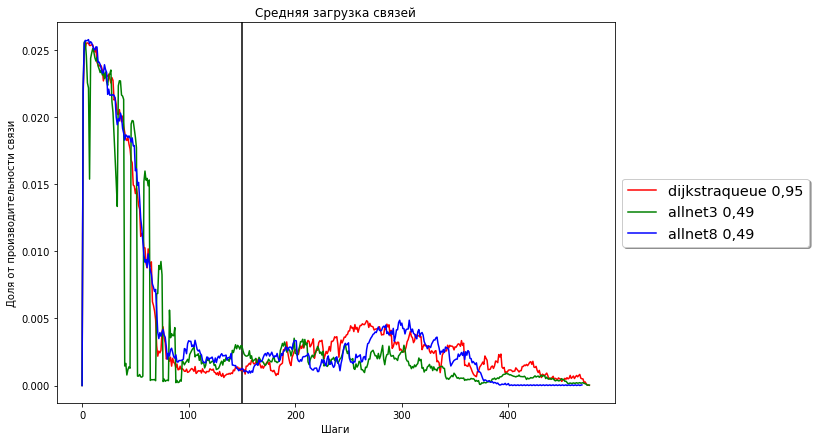

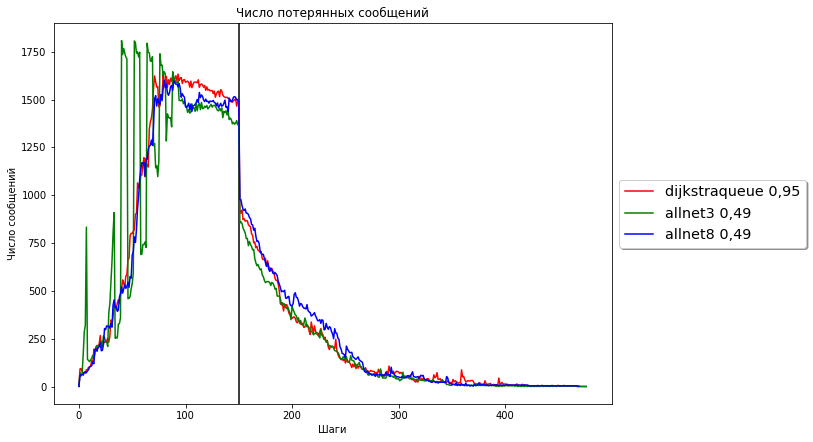

Доставлено 8629 Потеряно 96.1649% -dijkstraqueue 0,95
Доставлено 9074 Потеряно 95.9671% -allnet3 0,49
Доставлено 9402 Потеряно 95.8214% -allnet8 0,49


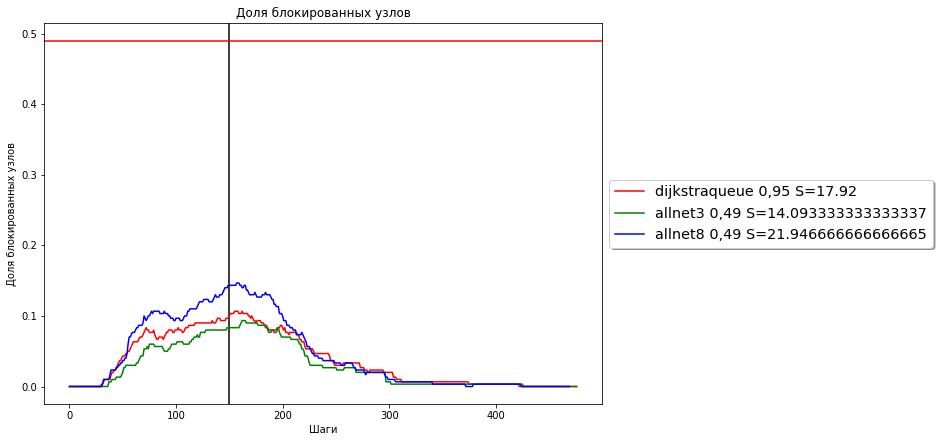

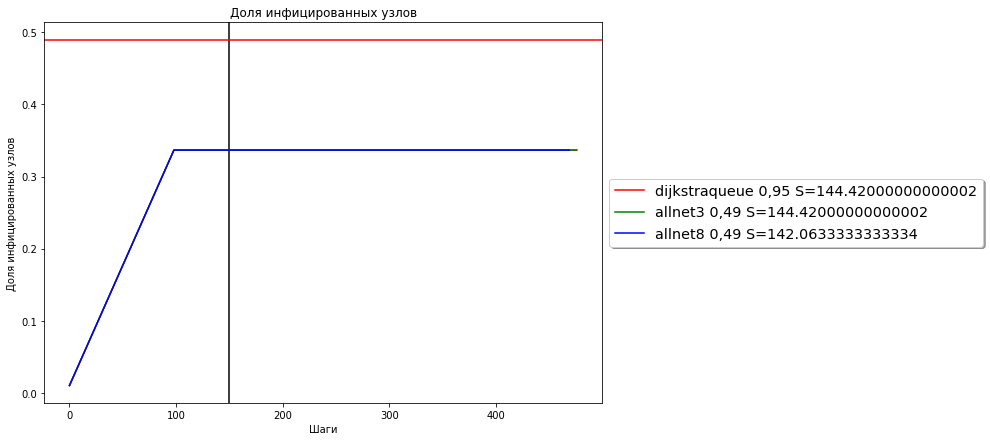

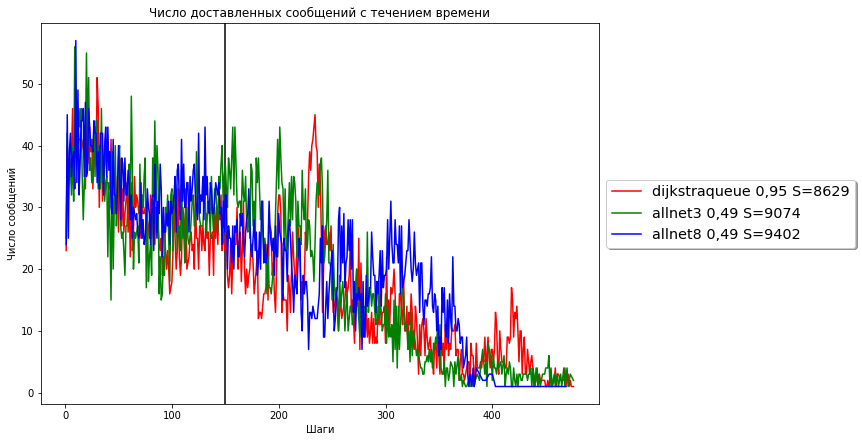

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "80605b35-04b1-452d-ba77-6c4803249c85", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "85531fc9-940e-487f-b0c8-0db7c18e8ab7", "label": "allnet3 0,49", "color": "green"},
{"tag":  "ea894288-7dd0-4cf8-a5ed-663666dd4f2e", "label": "allnet8 0,49", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 7265 Потеряно 83.8559% -dijkstraqueue 0,95
Доставлено 8395 Потеряно 81.3449% -allnet3 0,49
Доставлено 9055 Потеряно 79.8782% -allnet8 0,49


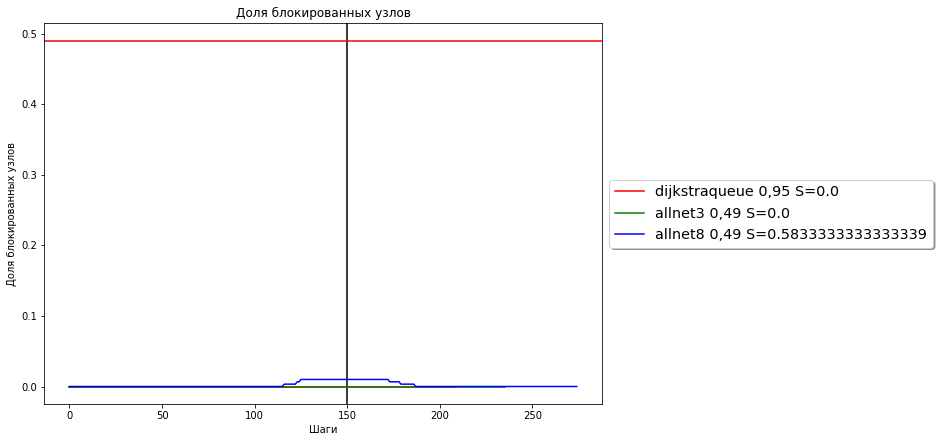

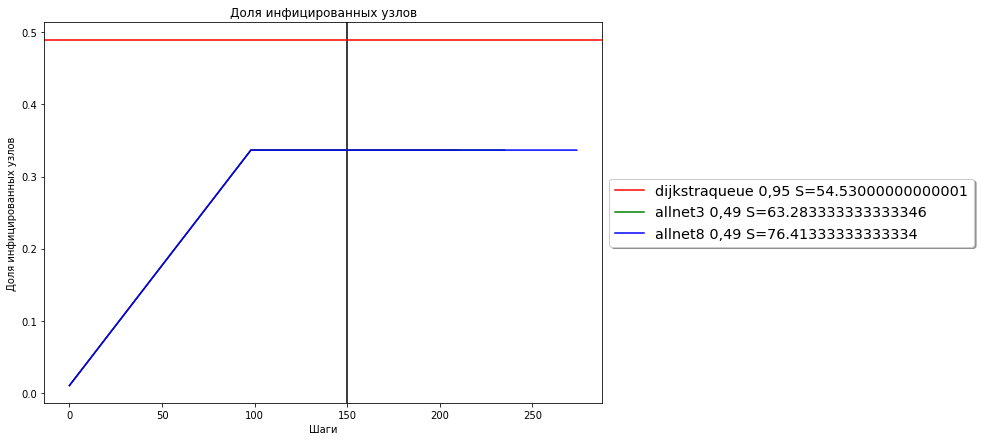

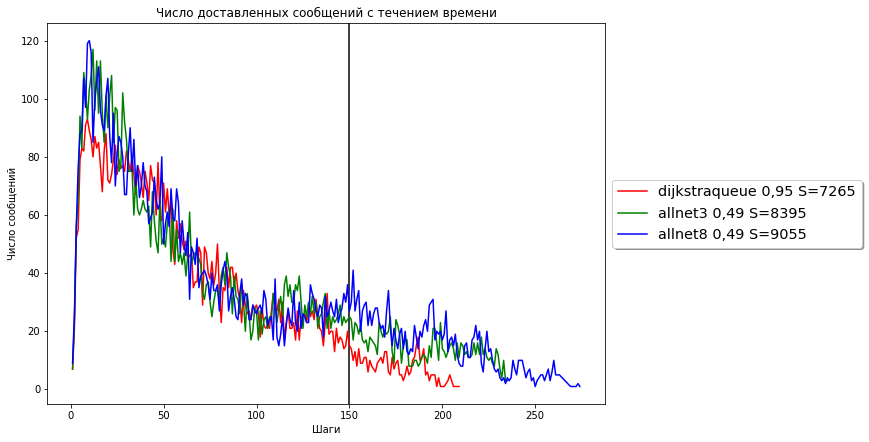

Доставлено 8412 Потеряно 91.9886% -dijkstraqueue 0,95
Доставлено 9624 Потеряно 90.8344% -allnet3 0,49
Доставлено 9035 Потеряно 91.3953% -allnet8 0,49


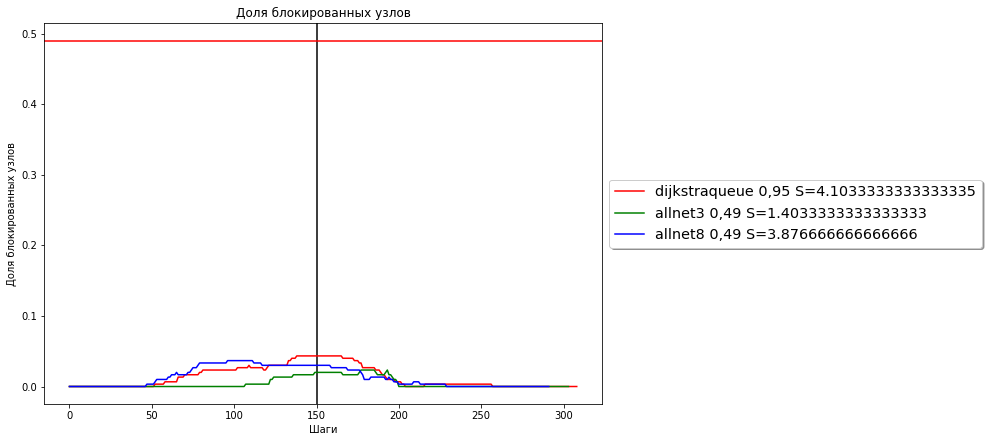

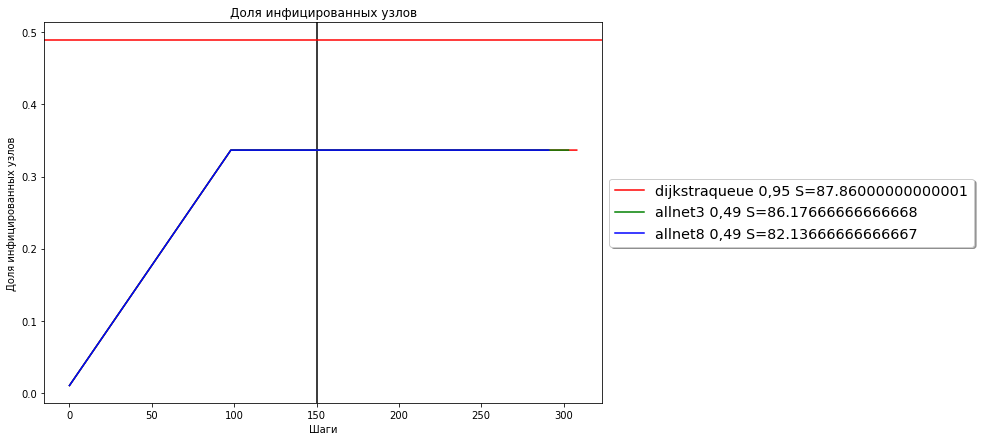

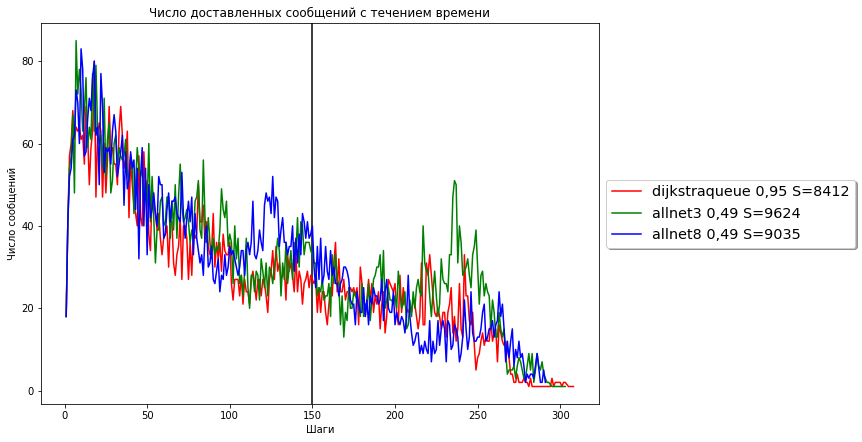

Доставлено 8138 Потеряно 93.9719% -dijkstraqueue 0,95
Доставлено 7018 Потеряно 94.8015% -allnet3 0,49
Доставлено 9168 Потеряно 93.2089% -allnet8 0,49


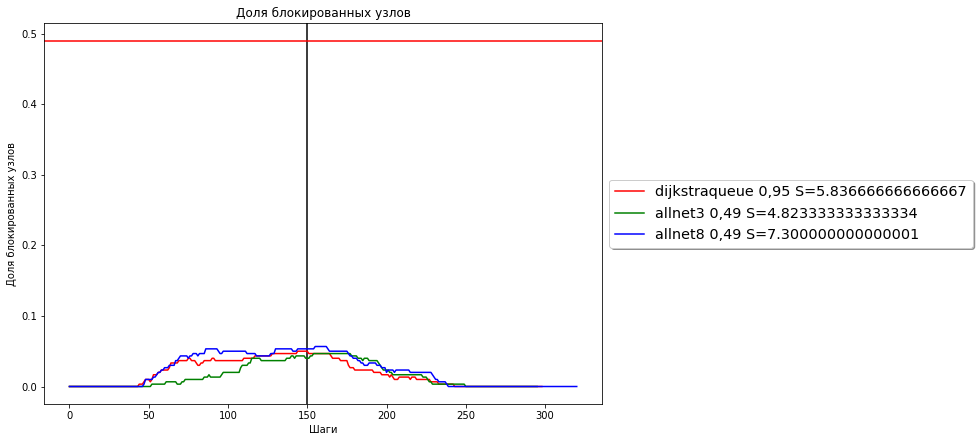

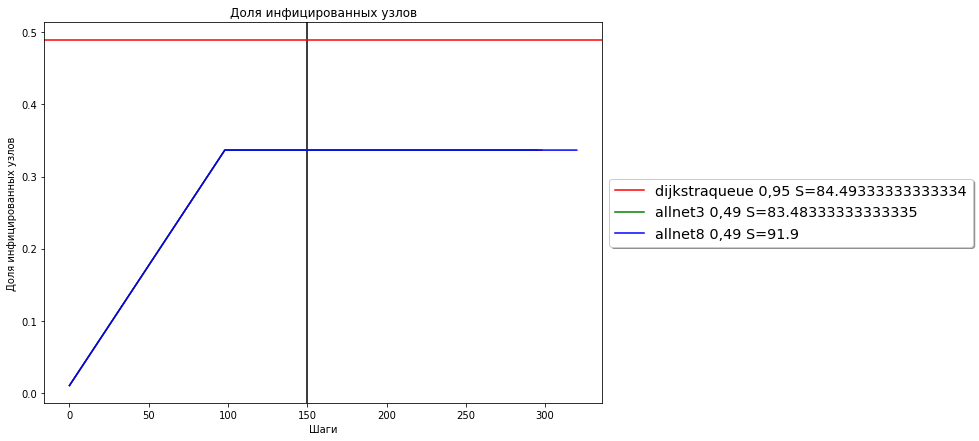

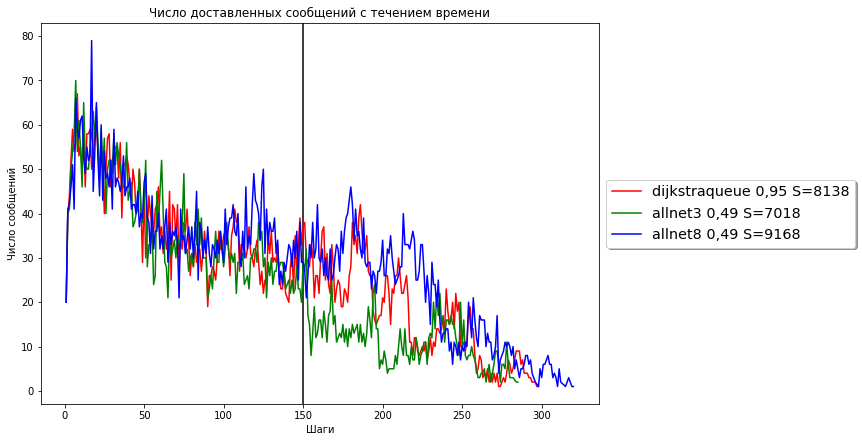

Доставлено 9712 Потеряно 95.0195% -dijkstraqueue 0,95
Доставлено 8779 Потеряно 95.4980% -allnet3 0,49
Доставлено 8317 Потеряно 95.7349% -allnet8 0,49


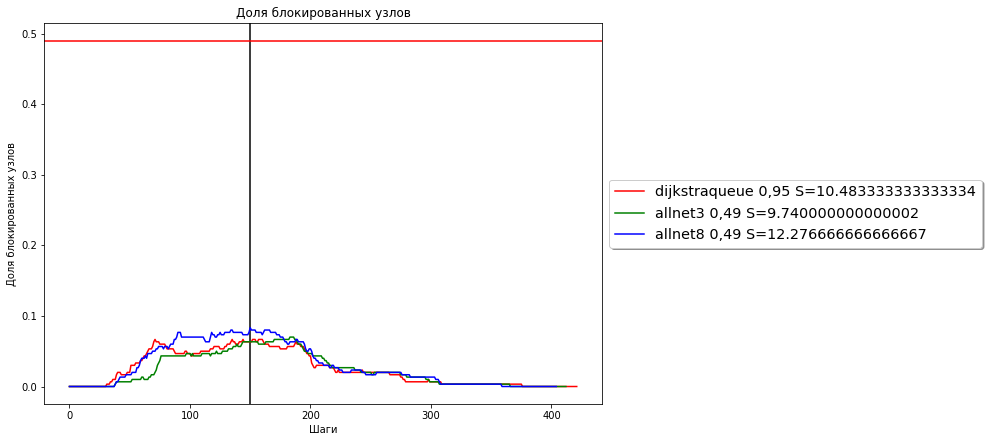

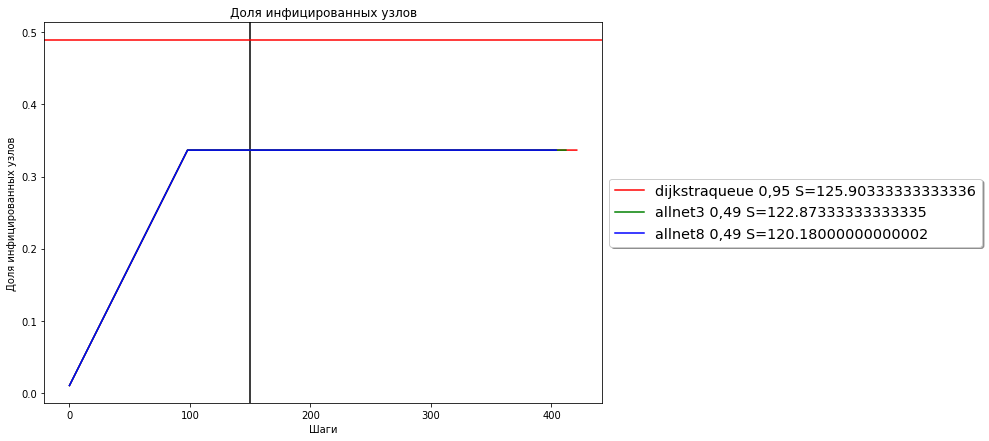

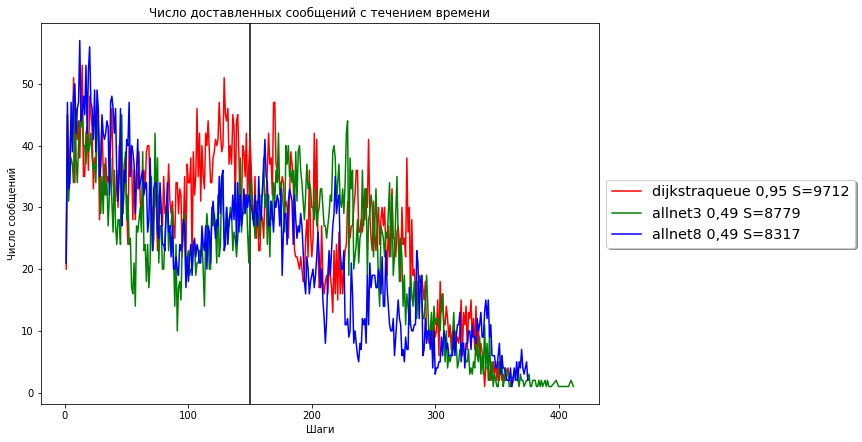

In [6]:
quantity = 300;
log_tags = [
{"tag":  "6e1275b3-f93c-4cbc-b0ec-2da69b3d1d4a", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "dadcd332-6211-449f-a0bd-37f87ea29069", "label": "allnet3 0,49", "color": "green"},
{"tag":  "dfa6db41-e49a-4ff0-a568-2558e3c5a883", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 700;
log_tags = [
{"tag":  "dd262792-a4fd-451e-a112-5ee3d6944263", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "571c9564-6a3a-4d3f-9f0c-3b01a52de4db", "label": "allnet3 0,49", "color": "green"},
{"tag":  "2f41f564-bd07-4a12-ba03-a3916d5349d2", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 900;
log_tags = [
{"tag":  "8d4e9e74-d1cb-41ff-ad0f-2b6ad4eb1ced", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "d17841c4-a6d5-4abb-aff4-14e6dbdaff8c", "label": "allnet3 0,49", "color": "green"},
{"tag":  "bab4d2aa-6e92-40dc-b398-2fad90d411c8", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 1300;
log_tags = [
{"tag":  "350d728e-fb55-425e-aa55-ec5392f8c53e", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "e3393038-83a5-4d1e-849b-e35669855b0e", "label": "allnet3 0,49", "color": "green"},
{"tag":  "67977eda-809f-4abe-901f-71b47d5ead68", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();
showStatMessage();

      dijkstraqueue 0,95  allnet3 0,49  allnet8 0,49
100             7.636424      4.519565      6.845077
300            18.774538     17.000711     31.197551
500            37.818229     27.472860     39.449261
700            32.797373     27.675079     31.477967
900            36.837031     31.557811     38.648936
1000           39.551023     29.309578     39.029926
1300           43.410526     38.680530     45.347839
1500           49.203515     42.763974     51.735695


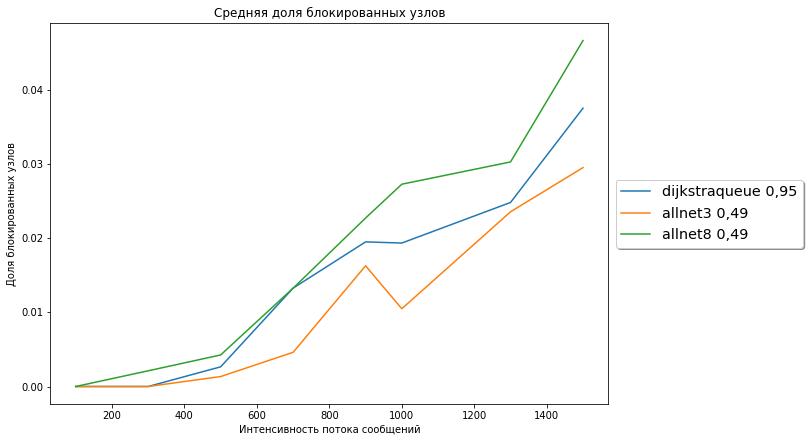

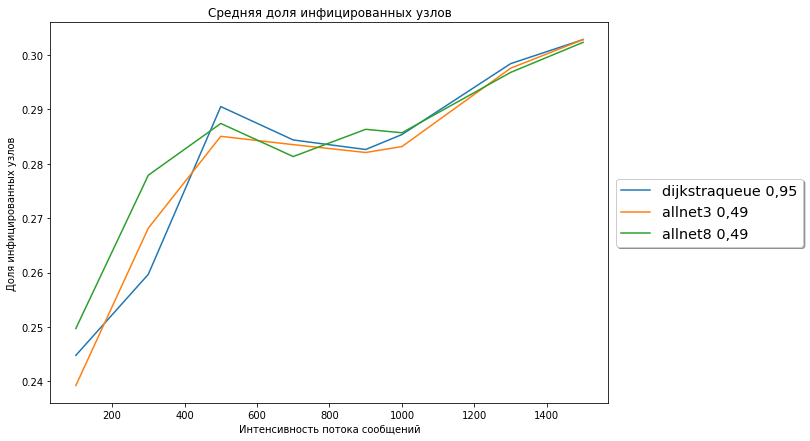

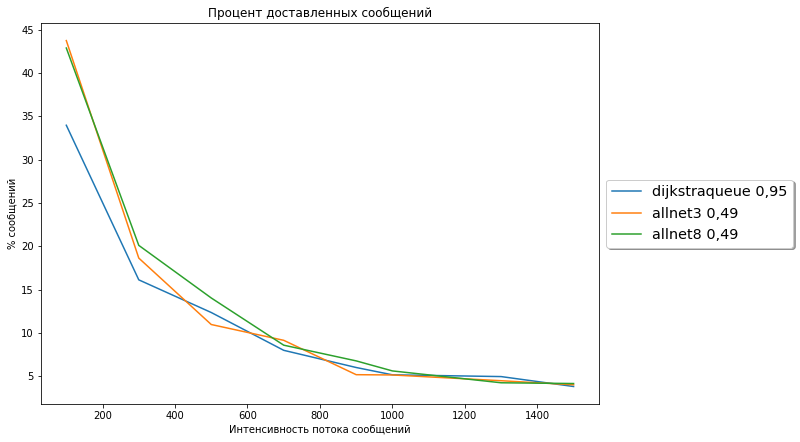

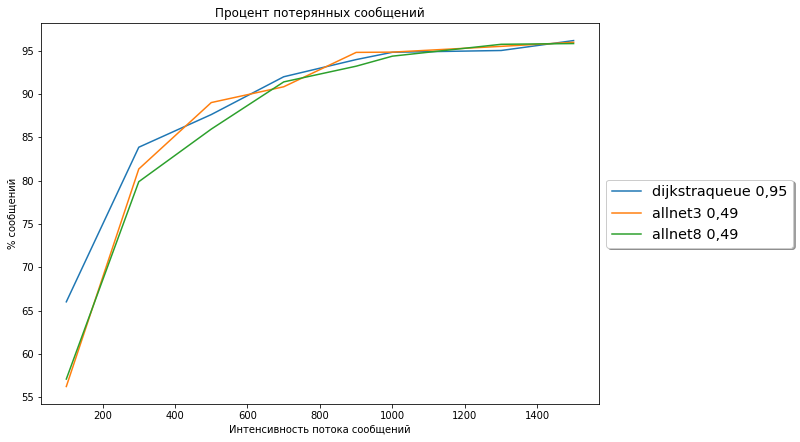

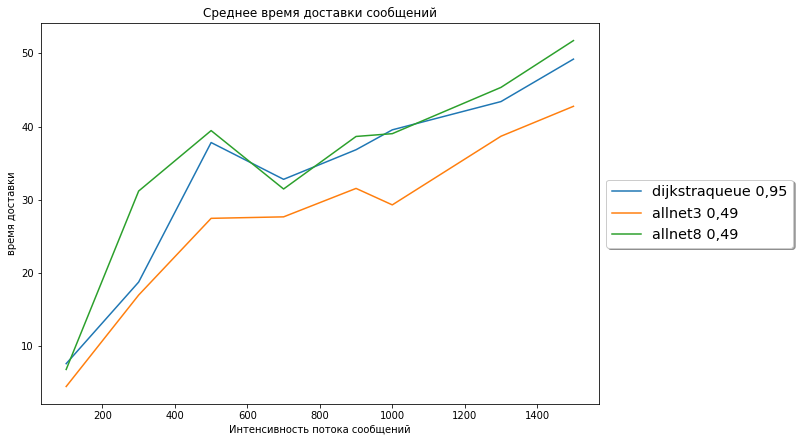

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

summInfected.sort_index(inplace=True)
axs = summInfected.plot()
axs.set_title("Средняя доля инфицированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля инфицированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()
print (MessageTimeSpent)

In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())
print("")
print(summInfected.mean().to_string())

dijkstraqueue 0,95    0.014654
allnet3 0,49          0.010735
allnet8 0,49          0.018339

dijkstraqueue 0,95    88.682334
allnet3 0,49          87.316536
allnet8 0,49          86.682143

dijkstraqueue 0,95    33.253582
allnet3 0,49          27.372514
allnet8 0,49          35.466531

dijkstraqueue 0,95    0.281037
allnet3 0,49          0.280166
allnet8 0,49          0.283401
